<a href="https://colab.research.google.com/github/CarolinaOliveira001/SupremeCourtJudgementPrediction/blob/main/secondTry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
import string
from nltk.stem import WordNetLemmatizer, PorterStemmer

In [ ]:
df = pd.read_csv("justice.csv")
df = df[["facts", "issue_area", "first_party_winner"]]
df.head(5)

,facts,issue_area,first_party_winner
0,"<p>In 1970, Jane Roe (a fictional name used in...",NaN,True
1,<p>Joan Stanley had three children with Peter ...,Civil Rights,True
2,<p>John Giglio was convicted of passing forged...,Due Process,True
3,"<p>The Idaho Probate Code specified that ""male...",Civil Rights,True
4,"<p>Miller, after conducting a mass mailing cam...",First Amendment,True


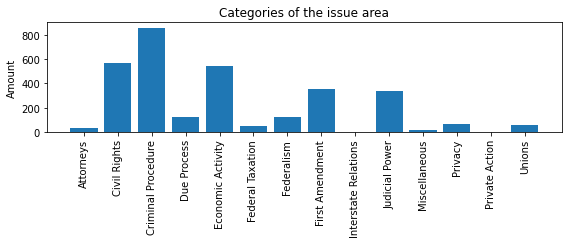

In [ ]:
freqTarget = df.groupby(["issue_area"], as_index=False, sort=True)["facts"].count()
vectorIA = ["Civil Rights", "Due Process", "First Amendment", "Criminal Procedure", "Privacy", "Federal Taxation", 
            "Economic Activity", "Judicial Power", "Unions", "Federalism", "Attorneys", "Miscellaneous", 
            "Interstate Relations", "Private Action"]

plt.rcParams["figure.figsize"] = [8, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.bar(freqTarget["issue_area"], freqTarget["facts"])
plt.xticks(freqTarget["issue_area"])
plt.title("Categories of the issue area")
plt.xticks(rotation=90)
plt.ylabel('Amount')
plt.savefig("IssueAreaOfFirstPlot.png", dpi=1200)
plt.show()

In [ ]:
len(df)

3303

In [ ]:
df['issue_area'] = df['issue_area'].replace({"Due Process": "Others", "Privacy": "Others", "Federal Taxation": "Others", 
                                                     "Unions": "Others", "Federalism": "Others", "Attorneys": "Others",
                                                     "Miscellaneous": "Others", "Interstate Relations": "Others", "Private Action": "Others"})

In [ ]:
df.isna().sum()

facts                   0
issue_area            142
first_party_winner     15
dtype: int64

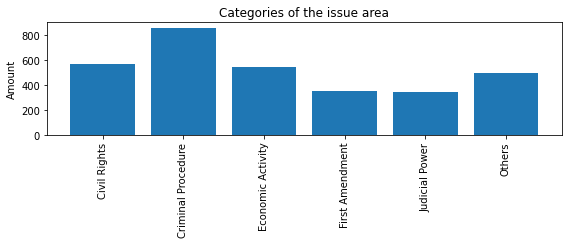

In [ ]:
freqTarget = df.groupby(["issue_area"], as_index=False, sort=True)["facts"].count()

plt.rcParams["figure.figsize"] = [8, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.bar(freqTarget["issue_area"], freqTarget["facts"])
plt.xticks(freqTarget["issue_area"])
plt.title("Categories of the issue area")
plt.xticks(rotation=90)
plt.ylabel('Amount')
plt.savefig("IssueAreaAfterCombiningCategoriesOfFirstPlot.png", dpi=1200)
plt.show()

In [ ]:
df.dropna(subset=['first_party_winner'], inplace=True)

In [ ]:
df.isna().sum()

facts                   0
issue_area            129
first_party_winner      0
dtype: int64

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [ ]:
le.fit(df["first_party_winner"])

LabelEncoder()

In [ ]:
df["first_party_winner"] = le.transform(df["first_party_winner"])

In [ ]:
df_withNA = df[df['issue_area'].isna()]
df_withNA = df_withNA.reset_index(drop=True)

In [ ]:
df_withoutNA = df.dropna(subset=['issue_area'])
df_withoutNA = df_withoutNA.reset_index(drop=True)

In [ ]:
print("There are", df_withoutNA['facts'].apply(lambda x: len(x.split(' '))).sum(), "words in the dataframe.")

There are 549349 words in the dataframe.


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = stopwords.words("english")
wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
pattern = r'[' + string.punctuation + ']'

def clean_text(text, stemming = False, lemmatization = False):
    """
        text: a string
        
        return: modified initial string
    """
    text = re.sub(pattern, " ", str(text))
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    text = re.sub(r"\W", " ", text)
    text = re.sub(' +', ' ', text)
    text = ' '.join(word for word in text.split() if word not in stop_words) # delete stopwors from text
    if stemming:
        st = PorterStemmer()
        text = " ".join([st.stem(w) for w in text.split()])
    
    if lemmatization:
        wordnet_lemmatizer = WordNetLemmatizer()
        text = ' '.join([wordnet_lemmatizer.lemmatize(w, pos='v') for w in text.split()])
    return text
    

In [ ]:
words_set = set()
 
for doc in df["facts"]:
  worddoc = doc.split()
  for word in worddoc:
    if word not in words_set:
      words_set.add(word)
     
print('Number of words in the corpus:',len(words_set))

Number of words in the corpus: 45672


In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
df_withoutNA['facts'] = df_withoutNA['facts'].map(lambda x: clean_text(x, stemming=False, lemmatization = True))

In [ ]:
df_withoutNA.head(3)

,facts,issue_area,first_party_winner
0,joan stanley three children peter stanley stan...,Civil Rights,1
1,john giglio convict pass forge money order app...,Others,1
2,idaho probate code specify males must prefer f...,Civil Rights,1


In [ ]:
print("There are",df_withoutNA['facts'].apply(lambda x: len(x.split(' '))).sum(), "words in the dataframe.")

There are 322095 words in the dataframe.


In [ ]:
my_issue_area = list(set(df_withoutNA["issue_area"]))

## Plots

In [ ]:
df['facts'] = df['facts'].map(lambda x: clean_text(x, stemming=False, lemmatization = True))

In [ ]:
words = []
freqOfWords = []

for doc in df["facts"]:
  worddoc = doc.split()
  for word in worddoc:
    if word not in words:
      words.append(word)
      freqOfWords.append(1)
    else:
      idx = words.index(word)
      freqOfWords[idx] = freqOfWords[idx] + 1

In [ ]:
d = {'words': words, 'frequency': freqOfWords}
freqWordDf = pd.DataFrame(data=d)
freqWordDf = freqWordDf.sort_values(by=['frequency'])

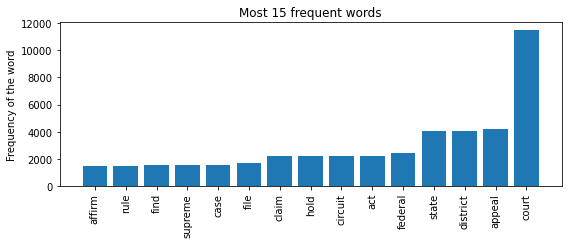

In [ ]:
plt.bar(freqWordDf.tail(15)["words"], freqWordDf.tail(15)["frequency"])
plt.xticks(freqWordDf.tail(15)["words"])
plt.title("Most 15 frequent words")
plt.ylabel('Frequency of the word')
plt.xticks(rotation = 90) 
plt.savefig("MostFrequentWordsInTheFirstDataset.png", dpi=1200)
plt.show()

In [ ]:
words = []
targetVar = []
onesList = []
for row in range(0, len(df_withoutNA["facts"])):
  worddoc = df_withoutNA["facts"][row].split()
  for word in worddoc:
    words.append(word)
    targetVar.append(df_withoutNA["first_party_winner"][row]) 
    onesList.append(1)

In [ ]:
d = {'words': words, 'first_party_winner': targetVar, "listOfOnes": onesList}
freqDf = pd.DataFrame(data=d)

In [ ]:
countFreqDf = freqDf.groupby(["first_party_winner", "words"], as_index=False, sort=True)["listOfOnes"].count()

In [ ]:
countFreqDfZeros = countFreqDf[countFreqDf['first_party_winner'].isin([0])].sort_values(by=['listOfOnes'])
countFreqDfZeros[countFreqDfZeros["listOfOnes"].isin([1])].count()

first_party_winner    2974
words                 2974
listOfOnes            2974
dtype: int64

In [ ]:
countFreqDfOnes = countFreqDf[countFreqDf['first_party_winner'].isin([1])].sort_values(by=['listOfOnes'])
countFreqDfOnes[countFreqDfOnes["listOfOnes"].isin([1])].count()

first_party_winner    3897
words                 3897
listOfOnes            3897
dtype: int64

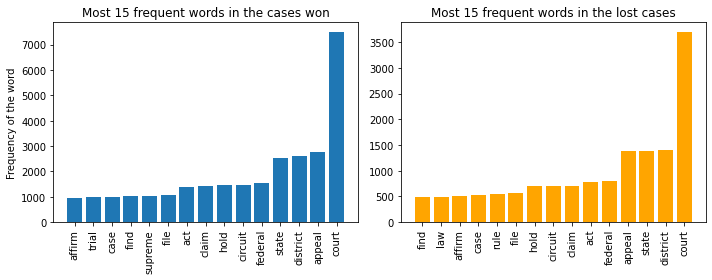

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].bar(countFreqDfOnes.tail(15)["words"], countFreqDfOnes.tail(15)["listOfOnes"])
axes[0].title.set_text("Most 15 frequent words in the cases won")
axes[0].set_xticklabels(countFreqDfOnes.tail(15)["words"], rotation=90)
axes[0].set_ylabel('Frequency of the word')

axes[1].bar(countFreqDfZeros.tail(15)["words"], countFreqDfZeros.tail(15)["listOfOnes"], color='orange')
axes[1].title.set_text("Most 15 frequent words in the lost cases")
axes[1].set_xticklabels(countFreqDfZeros.tail(15)["words"], rotation=90)

fig.savefig('MostFrequentWordsForEachCategoryFromTheFirstDataset.png', dpi=300)
fig.show()

# Without deleting most frequent words

In [ ]:
X = df_withoutNA.facts
y = df_withoutNA.issue_area
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [ ]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

CPU times: user 88.7 ms, sys: 2.01 ms, total: 90.7 ms
Wall time: 93.6 ms


In [ ]:
list(set(y_pred))

['Civil Rights',
 'First Amendment',
 'Economic Activity',
 'Criminal Procedure',
 'Others']

In [ ]:
list(set(y_test))

['Civil Rights',
 'First Amendment',
 'Economic Activity',
 'Judicial Power',
 'Criminal Procedure',
 'Others']

In [ ]:
import warnings
warnings.filterwarnings('always') #We can set it later to 'ignore'.

In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_issue_area))

accuracy 0.5580168776371308
                    precision    recall  f1-score   support

      Civil Rights       0.60      0.51      0.55       184
   First Amendment       0.51      0.99      0.67       258
 Economic Activity       0.64      0.63      0.64       161
    Judicial Power       0.84      0.17      0.28        96
Criminal Procedure       0.00      0.00      0.00       111
            Others       0.56      0.45      0.50       138

          accuracy                           0.56       948
         macro avg       0.53      0.46      0.44       948
      weighted avg       0.53      0.56      0.50       948



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [ ]:
%%time
y_pred = sgd.predict(X_test)

CPU times: user 207 ms, sys: 11.6 ms, total: 218 ms
Wall time: 222 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.6867088607594937
                    precision    recall  f1-score   support

    Judicial Power       0.74      0.65      0.69       184
   First Amendment       0.68      0.98      0.81       258
      Civil Rights       0.69      0.71      0.70       161
            Others       0.68      0.72      0.70        96
 Economic Activity       0.62      0.21      0.31       111
Criminal Procedure       0.64      0.52      0.57       138

          accuracy                           0.69       948
         macro avg       0.68      0.63      0.63       948
      weighted avg       0.68      0.69      0.66       948



In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, solver='lbfgs', max_iter=100000)),
               ])
logreg.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=100000.0, max_iter=100000, n_jobs=1))])

In [ ]:
%%time
y_pred = logreg.predict(X_test)

CPU times: user 203 ms, sys: 614 µs, total: 204 ms
Wall time: 205 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.7056962025316456
                    precision    recall  f1-score   support

            Others       0.72      0.69      0.71       184
 Economic Activity       0.78      0.94      0.85       258
   First Amendment       0.70      0.70      0.70       161
Criminal Procedure       0.70      0.77      0.74        96
      Civil Rights       0.53      0.31      0.39       111
    Judicial Power       0.62      0.58      0.60       138

          accuracy                           0.71       948
         macro avg       0.67      0.66      0.66       948
      weighted avg       0.69      0.71      0.69       948



In [ ]:
from sklearn.ensemble import RandomForestClassifier

randfor = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators= 10, max_depth=10, random_state=10)),
               ])
randfor.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 RandomForestClassifier(max_depth=10, n_estimators=10,
                                        random_state=10))])

In [ ]:
%%time
y_pred = randfor.predict(X_test)

CPU times: user 188 ms, sys: 973 µs, total: 189 ms
Wall time: 194 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.4272151898734177
                    precision    recall  f1-score   support

            Others       0.60      0.32      0.42       184
 Economic Activity       0.38      0.97      0.54       258
   First Amendment       0.46      0.35      0.39       161
Criminal Procedure       0.88      0.23      0.36        96
      Civil Rights       0.57      0.04      0.07       111
    Judicial Power       0.48      0.11      0.18       138

          accuracy                           0.43       948
         macro avg       0.56      0.33      0.33       948
      weighted avg       0.52      0.43      0.37       948



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
graboos = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', GradientBoostingClassifier(n_estimators=10, max_depth=10, random_state=10)),
               ])
graboos.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 GradientBoostingClassifier(max_depth=10, n_estimators=10,
                                            random_state=10))])

In [ ]:
%%time
y_pred = graboos.predict(X_test)

CPU times: user 195 ms, sys: 1.8 ms, total: 197 ms
Wall time: 197 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.6086497890295358
                    precision    recall  f1-score   support

            Others       0.63      0.54      0.58       184
 Economic Activity       0.70      0.88      0.78       258
   First Amendment       0.63      0.60      0.62       161
Criminal Procedure       0.68      0.64      0.66        96
      Civil Rights       0.47      0.28      0.35       111
    Judicial Power       0.40      0.44      0.42       138

          accuracy                           0.61       948
         macro avg       0.58      0.56      0.57       948
      weighted avg       0.60      0.61      0.60       948



In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [ ]:
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [ ]:
import xgboost as xgb

xgboo = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', xgb.XGBClassifier()),
               ])
xgboo.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', XGBClassifier(objective='multi:softprob'))])

In [ ]:
%%time
y_pred = xgboo.predict(X_test)

CPU times: user 279 ms, sys: 6.79 ms, total: 286 ms
Wall time: 285 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.6350210970464135
                    precision    recall  f1-score   support

            Others       0.67      0.60      0.63       184
 Economic Activity       0.74      0.89      0.81       258
   First Amendment       0.63      0.61      0.62       161
Criminal Procedure       0.63      0.70      0.66        96
      Civil Rights       0.47      0.27      0.34       111
    Judicial Power       0.45      0.47      0.46       138

          accuracy                           0.64       948
         macro avg       0.60      0.59      0.59       948
      weighted avg       0.62      0.64      0.62       948



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

kn = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('kn',KNeighborsClassifier(n_neighbors=3)),
               ])
kn.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('kn', KNeighborsClassifier(n_neighbors=3))])

In [ ]:
%%time
y_pred = kn.predict(X_test)

CPU times: user 384 ms, sys: 1.24 ms, total: 386 ms
Wall time: 388 ms


In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.5928270042194093
                    precision    recall  f1-score   support

            Others       0.50      0.70      0.58       184
 Economic Activity       0.66      0.81      0.73       258
   First Amendment       0.63      0.60      0.61       161
Criminal Procedure       0.65      0.48      0.55        96
      Civil Rights       0.50      0.23      0.32       111
    Judicial Power       0.59      0.40      0.47       138

          accuracy                           0.59       948
         macro avg       0.59      0.54      0.54       948
      weighted avg       0.59      0.59      0.58       948



# With deleting some words

In [ ]:
bunchOfWords = "".join(df_withoutNA["facts"].tolist())

We will perform a bag of words and try to find the words that appear 1000

In [ ]:
data_corpus = set()
for word in bunchOfWords.split(" "):
    if word not in data_corpus: 
        data_corpus.add(word)
data_corpus=sorted(data_corpus)

In [ ]:
def convert(set):
    return [*set, ]

data_corpus = convert(data_corpus)

In [ ]:
one_hot_encoding = []
split = bunchOfWords.split(" ")
for word in data_corpus:
    count = split.count(word) 
    if word in split:
        one_hot_encoding.append(count)
    else:
        one_hot_encoding.append(count)

In [ ]:
dfWords = pd.DataFrame({"words": data_corpus, "numberOfFrequency": one_hot_encoding})
dfWords["numberOfFrequency"] = pd.to_numeric(dfWords["numberOfFrequency"])

In [ ]:
irrelevantWords = dfWords[dfWords["numberOfFrequency"] > 1000]
irrelevantWords = set(irrelevantWords["words"])

In [ ]:
def more_clean_text(text):
    text = ' '.join(word for word in text.split() if word not in irrelevantWords) # delete stopwors from text
    return text

In [ ]:
df_withoutNA['facts'] = df_withoutNA['facts'].apply(more_clean_text)

In [ ]:
print("There are",df_withoutNA['facts'].apply(lambda x: len(x.split(' '))).sum(), "words in the dataframe.")

There are 267703 words in the dataframe.


In [ ]:
X = df_withoutNA.facts
y = df_withoutNA.issue_area
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

In [ ]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

CPU times: user 166 ms, sys: 1.7 ms, total: 167 ms
Wall time: 170 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_issue_area))

accuracy 0.520042194092827
                    precision    recall  f1-score   support

            Others       0.69      0.48      0.57       184
 Economic Activity       0.43      1.00      0.60       258
   First Amendment       0.63      0.61      0.62       161
Criminal Procedure       1.00      0.07      0.14        96
      Civil Rights       0.00      0.00      0.00       111
    Judicial Power       0.64      0.30      0.41       138

          accuracy                           0.52       948
         macro avg       0.57      0.41      0.39       948
      weighted avg       0.55      0.52      0.45       948



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [ ]:
%%time
y_pred = sgd.predict(X_test)

CPU times: user 215 ms, sys: 68.6 ms, total: 283 ms
Wall time: 217 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.6835443037974683
                    precision    recall  f1-score   support

            Others       0.76      0.65      0.70       184
 Economic Activity       0.66      0.98      0.79       258
   First Amendment       0.67      0.71      0.69       161
Criminal Procedure       0.73      0.72      0.72        96
      Civil Rights       0.60      0.19      0.29       111
    Judicial Power       0.65      0.51      0.57       138

          accuracy                           0.68       948
         macro avg       0.68      0.63      0.63       948
      weighted avg       0.68      0.68      0.66       948



In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, solver='lbfgs', max_iter=100000)),
               ])
logreg.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=100000.0, max_iter=100000, n_jobs=1))])

In [ ]:
%%time
y_pred = logreg.predict(X_test)

CPU times: user 165 ms, sys: 15.7 ms, total: 180 ms
Wall time: 167 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.7046413502109705
                    precision    recall  f1-score   support

            Others       0.74      0.68      0.71       184
 Economic Activity       0.75      0.94      0.83       258
   First Amendment       0.68      0.71      0.70       161
Criminal Procedure       0.70      0.76      0.73        96
      Civil Rights       0.55      0.29      0.38       111
    Judicial Power       0.65      0.59      0.62       138

          accuracy                           0.70       948
         macro avg       0.68      0.66      0.66       948
      weighted avg       0.69      0.70      0.69       948



In [ ]:
from sklearn.ensemble import RandomForestClassifier

randfor = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators= 10, max_depth=10, random_state=10)),
               ])
randfor.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 RandomForestClassifier(max_depth=10, n_estimators=10,
                                        random_state=10))])

In [ ]:
%%time
y_pred = randfor.predict(X_test)

CPU times: user 176 ms, sys: 3.97 ms, total: 180 ms
Wall time: 182 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.4208860759493671
                    precision    recall  f1-score   support

            Others       0.55      0.32      0.40       184
 Economic Activity       0.39      0.98      0.56       258
   First Amendment       0.43      0.35      0.39       161
Criminal Procedure       0.75      0.16      0.26        96
      Civil Rights       0.57      0.04      0.07       111
    Judicial Power       0.34      0.08      0.13       138

          accuracy                           0.42       948
         macro avg       0.51      0.32      0.30       948
      weighted avg       0.48      0.42      0.35       948



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
graboos = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', GradientBoostingClassifier(n_estimators=10, max_depth=10, random_state=10)),
               ])
graboos.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 GradientBoostingClassifier(max_depth=10, n_estimators=10,
                                            random_state=10))])

In [ ]:
%%time
y_pred = graboos.predict(X_test)

CPU times: user 174 ms, sys: 147 µs, total: 174 ms
Wall time: 175 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.6054852320675106
                    precision    recall  f1-score   support

            Others       0.64      0.55      0.59       184
 Economic Activity       0.70      0.87      0.77       258
   First Amendment       0.60      0.57      0.59       161
Criminal Procedure       0.65      0.57      0.61        96
      Civil Rights       0.53      0.27      0.36       111
    Judicial Power       0.41      0.52      0.46       138

          accuracy                           0.61       948
         macro avg       0.59      0.56      0.56       948
      weighted avg       0.60      0.61      0.60       948



In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [ ]:
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [ ]:
import xgboost as xgb

xgboo = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', xgb.XGBClassifier()),
               ])
xgboo.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', XGBClassifier(objective='multi:softprob'))])

In [ ]:
%%time
y_pred = xgboo.predict(X_test)

CPU times: user 272 ms, sys: 4.83 ms, total: 277 ms
Wall time: 276 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.6244725738396625
                    precision    recall  f1-score   support

            Others       0.64      0.55      0.59       184
 Economic Activity       0.73      0.91      0.81       258
   First Amendment       0.62      0.58      0.60       161
Criminal Procedure       0.67      0.65      0.66        96
      Civil Rights       0.47      0.29      0.36       111
    Judicial Power       0.44      0.50      0.47       138

          accuracy                           0.62       948
         macro avg       0.59      0.58      0.58       948
      weighted avg       0.62      0.62      0.61       948



In [ ]:
kn = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier(n_neighbors=3)),
               ])
kn.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier(n_neighbors=3))])

In [ ]:
%%time
y_pred = kn.predict(X_test)

CPU times: user 315 ms, sys: 2.35 ms, total: 318 ms
Wall time: 322 ms


In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.5780590717299579
                    precision    recall  f1-score   support

            Others       0.47      0.66      0.55       184
 Economic Activity       0.67      0.80      0.73       258
   First Amendment       0.59      0.60      0.60       161
Criminal Procedure       0.66      0.50      0.57        96
      Civil Rights       0.45      0.18      0.26       111
    Judicial Power       0.54      0.41      0.46       138

          accuracy                           0.58       948
         macro avg       0.56      0.52      0.53       948
      weighted avg       0.57      0.58      0.56       948



# Word2Vec

In [ ]:
pip install --upgrade tensorflow-hub

In [ ]:
pip install tensorflow_text

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

ModuleNotFoundError: ignored

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_withoutNA["facts"],df_withoutNA["issue_area"],test_size=0.2,shuffle=True)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [ ]:
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=2, batch_size = 32)

Epoch 1/2
79/79 [==============================] - 1090s 13s/step - loss: -13.0583 - accuracy: 0.2731
Epoch 2/2
79/79 [==============================] - 1056s 13s/step - loss: -40.5781 - accuracy: 0.2762


In [ ]:
y_train

array([1, 3, 2, ..., 0, 1, 3])

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
print(y_predicted)

20/20 [==============================] - 259s 13s/step
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [ ]:
print('accuracy %s' % accuracy_score(y_predicted, y_test))
print(classification_report(y_test, y_predicted,target_names=my_issue_area))

accuracy 0.254746835443038
                    precision    recall  f1-score   support

            Others       0.00      0.00      0.00       113
    Judicial Power       0.25      1.00      0.41       161
Criminal Procedure       0.00      0.00      0.00       104
 Economic Activity       0.00      0.00      0.00        70
      Civil Rights       0.00      0.00      0.00        69
   First Amendment       0.00      0.00      0.00       115

          accuracy                           0.25       632
         macro avg       0.04      0.17      0.07       632
      weighted avg       0.06      0.25      0.10       632



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Issue Area prediction

In [ ]:
second_df = pd.read_csv("us_classactions_verdicts.csv")
second_df = second_df[["target_text", "verdict"]]

In [ ]:
second_df.rename(columns = {'target_text':'facts', 'verdict': 'first_party_winner'}, inplace = True)

In [ ]:
second_df.head(3)

,facts,first_party_winner
0,Knowing and/or Willful Violation of the Telep...,lose
1,17. Defendants operate an electrical construc...,win
2,(Fair Labor Standards Act Violations) (Viola...,win


In [ ]:
len(second_df)

3000

In [ ]:
second_df.isna().sum()

facts                 4
first_party_winner    0
dtype: int64

In [ ]:
second_df.dropna(inplace = True)

In [ ]:
second_df.isna().sum()

facts                 0
first_party_winner    0
dtype: int64

In [ ]:
words_set = set()
 
for doc in second_df["facts"]:
  worddoc = doc.split()
  for word in worddoc:
    if word not in words_set:
      words_set.add(word)
     
print('Number of words in the corpus:',len(words_set))

Number of words in the corpus: 94528


In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [ ]:
le.fit(second_df["first_party_winner"])

LabelEncoder()

In [ ]:
second_df["first_party_winner"] = le.transform(second_df["first_party_winner"])

In [ ]:
second_df['facts'] = second_df['facts'].map(lambda x: clean_text(x, stemming=False, lemmatization = True))
df_withNA['facts'] = df_withNA['facts'].map(lambda x: clean_text(x, stemming=False, lemmatization = True))

In [ ]:
words_set = set()
 
for doc in second_df["facts"]:
  worddoc = doc.split()
  for word in worddoc:
    if word not in words_set:
      words_set.add(word)
     
print('Number of words in the corpus:',len(words_set))

Number of words in the corpus: 24684


In [ ]:
words_set = set()
 
for doc in df_withoutNA["facts"]:
  worddoc = doc.split()
  for word in worddoc:
    if word not in words_set:
      words_set.add(word)
     
print('Number of words in the corpus:',len(words_set))

Number of words in the corpus: 15335


In [ ]:
from locale import textdomain
def deleteWordsNotInFirstDataset(text):
    text = ' '.join(word for word in text.split() if word in words_set) # delete stopwors from text
    return text

In [ ]:
second_df['facts'] = second_df['facts'].map(lambda x: deleteWordsNotInFirstDataset(x))
df_withNA['facts'] = df_withNA['facts'].map(lambda x: deleteWordsNotInFirstDataset(x))

In [ ]:
words_set = set()
 
for doc in second_df["facts"]:
  worddoc = doc.split()
  for word in worddoc:
    if word not in words_set:
      words_set.add(word)
     
print('Number of words in the corpus:',len(words_set))

Number of words in the corpus: 9045


In [ ]:
words = []
freqOfWords = []

for doc in second_df["facts"]:
  worddoc = doc.split()
  for word in worddoc:
    if word not in words:
      words.append(word)
      freqOfWords.append(1)
    else:
      idx = words.index(word)
      freqOfWords[idx] = freqOfWords[idx] + 1

In [ ]:
d = {'words': words, 'frequency': freqOfWords}
freqWordDf = pd.DataFrame(data=d)
freqWordDf = freqWordDf.sort_values(by=['frequency'])

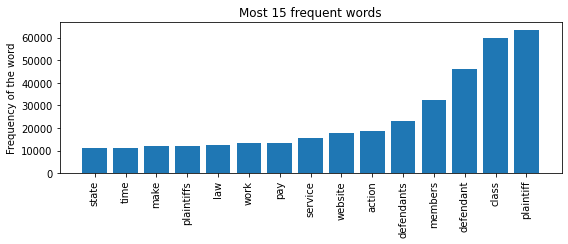

In [ ]:
plt.bar(freqWordDf.tail(15)["words"], freqWordDf.tail(15)["frequency"])
plt.xticks(freqWordDf.tail(15)["words"])
plt.title("Most 15 frequent words")
plt.ylabel('Frequency of the word')
plt.xticks(rotation = 90) 
plt.savefig("MostFrequentWordsInTheSecondDataset.png", dpi=1200)
plt.show()

In [ ]:
second_df.reset_index(drop = True, inplace=True)

In [ ]:
second_df.isna().sum()

facts                 0
first_party_winner    0
dtype: int64

In [ ]:
words = []
targetVar = []
onesList = []
for row in range(0, len(second_df["facts"])):
  worddoc = second_df["facts"][row].split()
  for word in worddoc:
    words.append(word)
    targetVar.append(second_df["first_party_winner"][row]) 
    onesList.append(1)

In [ ]:
d = {'words': words, 'first_party_winner': targetVar, "listOfOnes": onesList}
freqDf = pd.DataFrame(data=d)

In [ ]:
countFreqDf = freqDf.groupby(["first_party_winner", "words"], as_index=False, sort=True)["listOfOnes"].count()

In [ ]:
countFreqDfZeros = countFreqDf[countFreqDf['first_party_winner'].isin([0])].sort_values(by=['listOfOnes'])
countFreqDfZeros[countFreqDfZeros["listOfOnes"].isin([1])].count()

first_party_winner    1251
words                 1251
listOfOnes            1251
dtype: int64

In [ ]:
countFreqDfOnes = countFreqDf[countFreqDf['first_party_winner'].isin([1])].sort_values(by=['listOfOnes'])
countFreqDfOnes[countFreqDfOnes["listOfOnes"].isin([1])].count()

first_party_winner    1184
words                 1184
listOfOnes            1184
dtype: int64

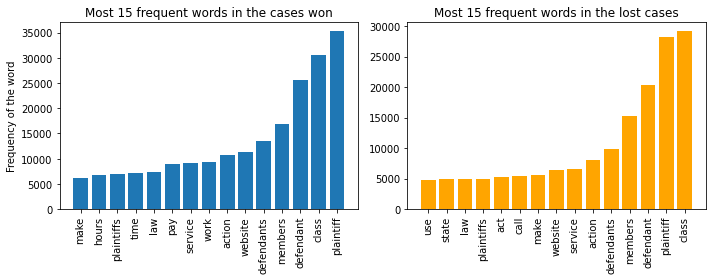

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].bar(countFreqDfOnes.tail(15)["words"], countFreqDfOnes.tail(15)["listOfOnes"])
axes[0].title.set_text("Most 15 frequent words in the cases won")
axes[0].set_xticklabels(countFreqDfOnes.tail(15)["words"], rotation=90)
axes[0].set_ylabel('Frequency of the word')

axes[1].bar(countFreqDfZeros.tail(15)["words"], countFreqDfZeros.tail(15)["listOfOnes"], color='orange')
axes[1].title.set_text("Most 15 frequent words in the lost cases")
axes[1].set_xticklabels(countFreqDfZeros.tail(15)["words"], rotation=90)

fig.savefig('MostFrequentWordsForEachCategoryFromTheSecondDataset.png', dpi=300)
fig.show()

In [ ]:
df_withNA = df_withNA[["facts", "first_party_winner"]]

In [ ]:
df_toPredict = pd.concat([df_withNA, second_df])
df_toPredict = df_toPredict.reset_index(drop=True)

In [ ]:
df_toPredict

,facts,first_party_winner
0,jane roe fictional name use court document pro...,1
1,wiley residents mobile alabama bring class act...,1
2,county los angeles impose ad valorem tax manuf...,0
3,island artificial island coast ventura county ...,1
4,president jimmy carter act without congression...,0
...,...,...
3120,fair labor standards act violations violations...,1
3121,guidelines regularly test user accessibility b...,0
3122,action bring class action plaintiff bring acti...,1
3123,discovery may reveal transmission additional f...,0


In [ ]:
X = df_withoutNA.facts
y = df_withoutNA.issue_area
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pie = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
               ])

In [ ]:
logreg = LogisticRegression(n_jobs=1, solver='lbfgs', max_iter=100000)

In [ ]:
logreg.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'logistic', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'logistic__C', 'logistic__class_weight', 'logistic__dual', 'logistic__fit_intercept', 'logistic__intercept_scaling', 'logistic__l1_ratio', 'logistic__max_iter', 'logistic__multi_class', 'logistic__n_jobs', 'logistic__penalty', 'logistic__random_state', 'logistic__solver', 'logistic__tol', 'logistic__verbose', 'logistic__warm_start'])

In [ ]:
params={'logistic__C':[1e4, 1e5, 1e6],
        'logistic__penalty' : ['none', 'l2']}

In [ ]:
feature_names = logreg.named_steps["logistic"].get_feature_names()

AttributeError: ignored

In [ ]:
(pd.Series(logreg.feature_importances_, index=X_train.columns).nlargest(10).plot(kind='barh')) 

AttributeError: ignored

In [ ]:
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
grid = HalvingGridSearchCV(logreg, cv=5, n_jobs=-1, param_grid=params)

In [ ]:
grid.fit(X_train, y_train)

HalvingGridSearchCV(estimator=Pipeline(steps=[('vect',
                                               CountVectorizer(ngram_range=(1,
                                                                            2))),
                                              ('tfidf', TfidfTransformer()),
                                              ('logistic',
                                               LogisticRegression(max_iter=100000,
                                                                  n_jobs=1))]),
                    n_jobs=-1,
                    param_grid={'logistic__C': [10000.0, 100000.0, 1000000.0],
                                'logistic__penalty': ['none', 'l2']})

In [ ]:
print("Best parameter (CV score=%0.3f):" % grid.best_score_)

Best parameter (CV score=0.713):


In [ ]:
%%time
from sklearn.metrics import classification_report
y_pred = grid.predict(X_test)

CPU times: user 140 ms, sys: 2.52 ms, total: 143 ms
Wall time: 145 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.7088607594936709
                    precision    recall  f1-score   support

            Others       0.74      0.77      0.75       108
 Economic Activity       0.75      0.94      0.84       173
Criminal Procedure       0.63      0.69      0.66        98
    Judicial Power       0.75      0.79      0.77        71
      Civil Rights       0.56      0.30      0.39        81
   First Amendment       0.69      0.53      0.60       101

          accuracy                           0.71       632
         macro avg       0.69      0.67      0.67       632
      weighted avg       0.70      0.71      0.69       632



In [ ]:
%%time
from sklearn.metrics import classification_report
y_pred = grid.predict(df_toPredict["facts"])

CPU times: user 3.55 s, sys: 30.8 ms, total: 3.58 s
Wall time: 3.6 s


In [ ]:
y_pred_df = pd.DataFrame({"issue_area": y_pred})

In [ ]:
df_toPredict = pd.concat([df_toPredict, y_pred_df], axis = 1)
df_toPredict = df_toPredict[["facts", "issue_area", "first_party_winner"]]

In [ ]:
big_df = pd.concat([df_withoutNA, df_toPredict])
big_df = big_df.reset_index(drop=True)

In [ ]:
big_df

,facts,issue_area,first_party_winner
0,joan stanley three children peter stanley stan...,Civil Rights,1
1,john giglio convict pass forge money order app...,Others,1
2,idaho probate code specify males must prefer f...,Civil Rights,1
3,miller conduct mass mail campaign advertise sa...,First Amendment,1
4,ernest mandel belgian professional journalist ...,First Amendment,1
...,...,...,...
6279,fair labor standards act violations violations...,Others,1
6280,guidelines regularly test user accessibility b...,Civil Rights,0
6281,action bring class action plaintiff bring acti...,Judicial Power,1
6282,discovery may reveal transmission additional f...,Judicial Power,0


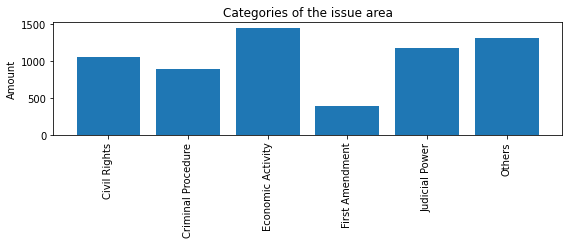

In [ ]:
freqTarget = big_df.groupby(["issue_area"], as_index=False, sort=True)["facts"].count()

plt.rcParams["figure.figsize"] = [8, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.bar(freqTarget["issue_area"], freqTarget["facts"])
plt.xticks(freqTarget["issue_area"])
plt.title("Categories of the issue area")
plt.xticks(rotation=90)
plt.ylabel('Amount')
plt.savefig("IssueAreaForBothDatasets.png", dpi=1200)
plt.show()

# One Hot Encoding


In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore')

In [ ]:
encoder_df = pd.DataFrame(encoder.fit_transform(big_df[['issue_area']]).toarray())

In [ ]:
encoder_df.columns = ['Civil Rights', 'Criminal Procedure', 'Economic Activity',
                      'First Amendment', 'Judicial Power', 'Others']

In [ ]:
big_df = big_df.join(encoder_df)
big_df.drop('issue_area', axis=1, inplace=True)

In [ ]:
big_df[['Civil Rights', 'Criminal Procedure', 'Economic Activity',
                      'First Amendment', 'Judicial Power', 'Others']] = big_df[['Civil Rights', 'Criminal Procedure', 'Economic Activity',
                      'First Amendment', 'Judicial Power', 'Others']].astype(int)

In [ ]:
big_df = big_df[["facts", 'Civil Rights', 'Criminal Procedure', 'Economic Activity',
                      'First Amendment', 'Judicial Power', 'Others', "first_party_winner"]]

In [ ]:
big_df

,facts,Civil Rights,Criminal Procedure,Economic Activity,First Amendment,Judicial Power,Others,first_party_winner
0,joan stanley three children peter stanley stan...,1,0,0,0,0,0,1
1,john giglio convict pass forge money order app...,0,0,0,0,0,1,1
2,idaho probate code specify males must prefer f...,1,0,0,0,0,0,1
3,miller conduct mass mail campaign advertise sa...,0,0,0,1,0,0,1
4,ernest mandel belgian professional journalist ...,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...
6279,fair labor standards act violations violations...,0,0,0,0,0,1,1
6280,guidelines regularly test user accessibility b...,1,0,0,0,0,0,0
6281,action bring class action plaintiff bring acti...,0,0,0,0,1,0,1
6282,discovery may reveal transmission additional f...,0,0,0,0,1,0,0


In [ ]:
big_df.rename(columns = {'first_party_winner':'target'}, inplace = True)

# Second Prediction with TFIDF

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(big_df, test_size=0.3, random_state=42)

In [ ]:
numberOfZerosForTraining = 0
numberOfOnesForTraining = 0

for i in X_train['target']:
  if i == 0:
    numberOfZerosForTraining += 1
  if i == 1:
    numberOfOnesForTraining += 1

labelsPiechart = ['True', 'False']
numbersPiechart = np.array([numberOfZerosForTraining, numberOfOnesForTraining])

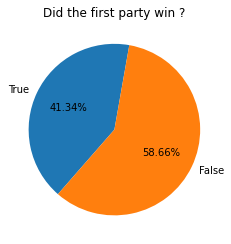

In [ ]:
plt.pie(numbersPiechart, labels = labelsPiechart, startangle = 80, autopct='%1.2f%%')
plt.title("Did the first party win ?")
plt.savefig("ImbalancedSplit.png", dpi=1200)
plt.show() 

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [ ]:
y_train = X_train["target"]

In [ ]:
X_train = X_train.loc[:, X_train.columns != 'target']

In [ ]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)

In [ ]:
X_train = X_train_ros
y_train = y_train_ros

In [ ]:
y_test = X_test["target"]
X_test = X_test.loc[:, X_test.columns != 'target']

In [ ]:
numberOfZerosForTraining = 0
numberOfOnesForTraining = 0

for i in y_train:
  if i == 0:
    numberOfZerosForTraining += 1
  if i == 1:
    numberOfOnesForTraining += 1

labelsPiechart = ['True', 'False']
numbersPiechart = np.array([numberOfZerosForTraining, numberOfOnesForTraining])

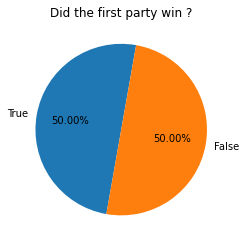

In [ ]:
plt.pie(numbersPiechart, labels = labelsPiechart, startangle = 80, autopct='%1.2f%%')
plt.title("Did the first party win ?")
plt.savefig("BalancedSplit.png", dpi=1200)
plt.show() 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer_tf = TfidfVectorizer(max_df=0.75, max_features=1000, ngram_range=(1,2))

In [ ]:
train_vectors = vectorizer_tf.fit_transform(X_train.facts) 
test_vectors = vectorizer_tf.transform(X_test.facts)

In [ ]:
train_df=pd.DataFrame(train_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
test_df=pd.DataFrame(test_vectors.toarray(), columns=vectorizer_tf.get_feature_names())

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
train_df=pd.concat([train_df,X_train.loc[:, X_train.columns != "facts"].reset_index(drop=True)], axis=1)
test_df=pd.concat([test_df,X_test.loc[:, X_test.columns != "facts"].reset_index(drop=True)], axis=1)

In [ ]:
train_df

,ability,able,access,access defendant,access facilities,access website,accessibility,accessible,accommodation,accommodations,...,years,york,york city,york state,Civil Rights,Criminal Procedure,Economic Activity,First Amendment,Judicial Power,Others
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0,0,0,0,0,1
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.021368,0.0,0.0,0,0,0,0,1,0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0,0,0,0,0,1
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0,0,0,1,0,0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.015445,0.0,0.0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5893,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0,1,0,0,0,0
5894,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0,1,0,0,0,0
5895,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.057466,0.000000,0.0,0.0,0,0,1,0,0,0
5896,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.073427,0.0,0.0,0,0,0,0,1,0


In [ ]:
train_df.to_csv('tfidf.csv', index=False)

In [ ]:
X_train_tf = train_df
X_test_tf = test_df

In [ ]:
my_target = ["0", "1"]

In [ ]:
from sklearn import linear_model, decomposition

In [ ]:
pca = decomposition.PCA()

In [ ]:
logreg = Pipeline([
                ('clf', LogisticRegression()),
               ])

In [ ]:
logreg.fit(X_train_tf, y_train)

Pipeline(steps=[('clf', LogisticRegression())])

In [ ]:
%%time
y_pred = logreg.predict(X_test_tf)

CPU times: user 22.1 ms, sys: 20 µs, total: 22.2 ms
Wall time: 26.1 ms


In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.60381861575179
              precision    recall  f1-score   support

           0       0.54      0.56      0.55       543
           1       0.66      0.64      0.65       714

    accuracy                           0.60      1257
   macro avg       0.60      0.60      0.60      1257
weighted avg       0.61      0.60      0.60      1257



In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([
    ('clf', MultinomialNB()),
              ])
nb.fit(X_train_tf, y_train)

Pipeline(steps=[('clf', MultinomialNB())])

In [ ]:
%%time
y_pred = nb.predict(X_test_tf)

CPU times: user 27.7 ms, sys: 7.88 ms, total: 35.6 ms
Wall time: 29.5 ms


In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6252983293556086
              precision    recall  f1-score   support

           0       0.58      0.47      0.52       543
           1       0.65      0.74      0.69       714

    accuracy                           0.63      1257
   macro avg       0.62      0.61      0.61      1257
weighted avg       0.62      0.63      0.62      1257



In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([
                ('clf', SGDClassifier()),
               ])
sgd.fit(X_train_tf, y_train)

Pipeline(steps=[('clf', SGDClassifier())])

In [ ]:
%%time
y_pred = sgd.predict(X_test_tf)

CPU times: user 21.7 ms, sys: 6.31 ms, total: 28 ms
Wall time: 28.9 ms


In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6014319809069213
              precision    recall  f1-score   support

           0       0.54      0.54      0.54       543
           1       0.65      0.65      0.65       714

    accuracy                           0.60      1257
   macro avg       0.59      0.59      0.59      1257
weighted avg       0.60      0.60      0.60      1257



In [ ]:
from sklearn.ensemble import RandomForestClassifier

randfor = RandomForestClassifier()
randfor.fit(X_train_tf, y_train)

RandomForestClassifier()

In [ ]:
%%time
y_pred = randfor.predict(X_test_tf)

CPU times: user 78.4 ms, sys: 3.03 ms, total: 81.5 ms
Wall time: 82.5 ms


In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6372315035799523
              precision    recall  f1-score   support

           0       0.61      0.44      0.51       543
           1       0.65      0.79      0.71       714

    accuracy                           0.64      1257
   macro avg       0.63      0.61      0.61      1257
weighted avg       0.63      0.64      0.62      1257



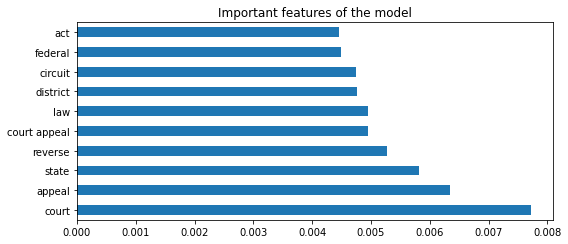

In [ ]:
table2 = pd.Series(randfor.feature_importances_, index=X_train_tf.columns).nlargest(10)
   
ax = table2.plot(kind='barh', title= "Important features of the model")
ax.figure.savefig('tf-randomForest.png')

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
graboos = Pipeline([
                ('clf', GradientBoostingClassifier()),
               ])
graboos.fit(X_train_tf, y_train)

Pipeline(steps=[('clf', GradientBoostingClassifier())])

In [ ]:
%%time
y_pred = graboos.predict(X_test_tf)

CPU times: user 32.3 ms, sys: 1.05 ms, total: 33.3 ms
Wall time: 38.6 ms


In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6133651551312649
              precision    recall  f1-score   support

           0       0.56      0.50      0.53       543
           1       0.65      0.70      0.67       714

    accuracy                           0.61      1257
   macro avg       0.60      0.60      0.60      1257
weighted avg       0.61      0.61      0.61      1257



In [ ]:
import xgboost as xgb

xgboo = Pipeline([
                ('clf', xgb.XGBClassifier()),
               ])
xgboo.fit(X_train_tf, y_train)

Pipeline(steps=[('clf', XGBClassifier())])

In [ ]:
%%time
y_pred = xgboo.predict(X_test_tf)

CPU times: user 47.4 ms, sys: 2.78 ms, total: 50.2 ms
Wall time: 47.8 ms


In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6149562450278441
              precision    recall  f1-score   support

           0       0.56      0.51      0.53       543
           1       0.65      0.69      0.67       714

    accuracy                           0.61      1257
   macro avg       0.61      0.60      0.60      1257
weighted avg       0.61      0.61      0.61      1257



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

kn = Pipeline([
              ('kn',KNeighborsClassifier(n_neighbors=3)),
               ])
kn.fit(X_train_tf, y_train)

Pipeline(steps=[('kn', KNeighborsClassifier(n_neighbors=3))])

In [ ]:
%%time
y_pred = kn.predict(X_test_tf)

CPU times: user 1.11 s, sys: 89.3 ms, total: 1.2 s
Wall time: 716 ms


In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.5624502784407319
              precision    recall  f1-score   support

           0       0.49      0.48      0.48       543
           1       0.61      0.63      0.62       714

    accuracy                           0.56      1257
   macro avg       0.55      0.55      0.55      1257
weighted avg       0.56      0.56      0.56      1257



# Second Prediction with Count

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_tf = CountVectorizer()

In [ ]:
train_vectors = vectorizer_tf.fit_transform(X_train.facts) 
test_vectors = vectorizer_tf.transform(X_test.facts)

In [ ]:
train_df=pd.DataFrame(train_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
test_df=pd.DataFrame(test_vectors.toarray(), columns=vectorizer_tf.get_feature_names())

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
train_df=pd.concat([train_df,X_train.loc[:, X_train.columns != "facts"].reset_index(drop=True)], axis=1)
test_df=pd.concat([test_df,X_test.loc[:, X_test.columns != "facts"].reset_index(drop=True)], axis=1)

In [ ]:
X_train_count = train_df
X_test_count = test_df

In [ ]:
logreg = Pipeline([
                ('clf', LogisticRegression()),
               ])
logreg.fit(X_train_count, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('clf', LogisticRegression())])

In [ ]:
%%time
y_pred = logreg.predict(X_test_count)

CPU times: user 454 ms, sys: 103 ms, total: 557 ms
Wall time: 477 ms


In [ ]:
my_target = ['0', '1']

In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.5719968178202068
              precision    recall  f1-score   support

           0       0.50      0.48      0.49       543
           1       0.62      0.64      0.63       714

    accuracy                           0.57      1257
   macro avg       0.56      0.56      0.56      1257
weighted avg       0.57      0.57      0.57      1257



In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([
                ('clf', SGDClassifier()),
               ])
sgd.fit(X_train_count, y_train)

Pipeline(steps=[('clf', SGDClassifier())])

In [ ]:
%%time
y_pred = sgd.predict(X_test_count)

CPU times: user 487 ms, sys: 10.7 ms, total: 498 ms
Wall time: 482 ms


In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.5894988066825776
              precision    recall  f1-score   support

           0       0.52      0.54      0.53       543
           1       0.64      0.63      0.63       714

    accuracy                           0.59      1257
   macro avg       0.58      0.58      0.58      1257
weighted avg       0.59      0.59      0.59      1257



In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([
    ('clf', MultinomialNB()),
              ])
nb.fit(X_train_count, y_train)

Pipeline(steps=[('clf', MultinomialNB())])

In [ ]:
%%time
y_pred = nb.predict(X_test_count)

CPU times: user 518 ms, sys: 11.3 ms, total: 529 ms
Wall time: 494 ms


In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6324582338902148
              precision    recall  f1-score   support

           0       0.58      0.52      0.55       543
           1       0.66      0.72      0.69       714

    accuracy                           0.63      1257
   macro avg       0.62      0.62      0.62      1257
weighted avg       0.63      0.63      0.63      1257



In [ ]:
from sklearn.ensemble import RandomForestClassifier

randfor = Pipeline([
    
                ('clf', RandomForestClassifier()),
               ])
randfor.fit(X_train_count, y_train)

Pipeline(steps=[('clf', RandomForestClassifier())])

In [ ]:
%%time
y_pred = randfor.predict(X_test_count)

CPU times: user 246 ms, sys: 2.82 ms, total: 249 ms
Wall time: 249 ms


In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6324582338902148
              precision    recall  f1-score   support

           0       0.60      0.43      0.50       543
           1       0.64      0.79      0.71       714

    accuracy                           0.63      1257
   macro avg       0.62      0.61      0.61      1257
weighted avg       0.63      0.63      0.62      1257



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
graboos = Pipeline([
                ('clf', GradientBoostingClassifier()),
               ])
graboos.fit(X_train_count, y_train)

Pipeline(steps=[('clf', GradientBoostingClassifier())])

In [ ]:
%%time
y_pred = graboos.predict(X_test_count)

CPU times: user 450 ms, sys: 9.14 ms, total: 459 ms
Wall time: 460 ms


In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6101829753381066
              precision    recall  f1-score   support

           0       0.56      0.47      0.51       543
           1       0.64      0.71      0.68       714

    accuracy                           0.61      1257
   macro avg       0.60      0.59      0.59      1257
weighted avg       0.60      0.61      0.60      1257



In [ ]:
import xgboost as xgb

xgboo = xgb.XGBClassifier()
xgboo.fit(X_train_count, y_train)

XGBClassifier()

In [ ]:
%%time
y_pred = xgboo.predict(X_test_count)

CPU times: user 500 ms, sys: 214 ms, total: 714 ms
Wall time: 715 ms


In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6260938743038982
              precision    recall  f1-score   support

           0       0.58      0.51      0.54       543
           1       0.66      0.72      0.68       714

    accuracy                           0.63      1257
   macro avg       0.62      0.61      0.61      1257
weighted avg       0.62      0.63      0.62      1257



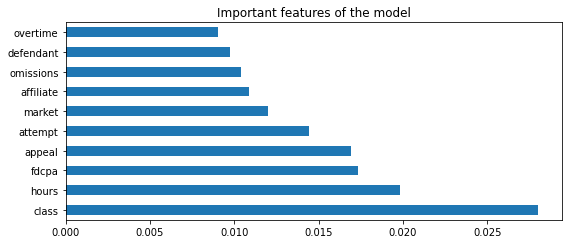

In [ ]:
table3 = pd.Series(xgboo.feature_importances_, index=X_train_count.columns).nlargest(10)
   
ax = table3.plot(kind='barh', title= "Important features of the model")
ax.figure.savefig('count-xgboo.png')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

kn = Pipeline([
    
                #('pca', pca),
              ('kn',KNeighborsClassifier(n_neighbors=15)),
               ])
kn.fit(X_train_count, y_train)

Pipeline(steps=[('kn', KNeighborsClassifier(n_neighbors=15))])

In [ ]:
%%time
y_pred = kn.predict(X_test_count)

CPU times: user 13.5 s, sys: 332 ms, total: 13.8 s
Wall time: 7.53 s


In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.5823389021479713
              precision    recall  f1-score   support

           0       0.52      0.57      0.54       543
           1       0.64      0.60      0.62       714

    accuracy                           0.58      1257
   macro avg       0.58      0.58      0.58      1257
weighted avg       0.59      0.58      0.58      1257



# Multiple test to improve the accuracy

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(big_df, test_size=0.2, random_state=42)

In [ ]:
y_train = X_train["target"]
X_train = X_train.loc[:, X_train.columns != 'target']

In [ ]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)

In [ ]:
X_train = X_train_ros
y_train = y_train_ros

In [ ]:
y_test = X_test["target"]
X_test = X_test.loc[:, X_test.columns != 'target']

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, solver='lbfgs', max_iter=100000)),
               ])
logreg.fit(X_train["facts"], y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=100000.0, max_iter=100000, n_jobs=1))])

In [ ]:
%%time
y_pred = logreg.predict(X_test["facts"])

CPU times: user 1.38 s, sys: 10.3 ms, total: 1.39 s
Wall time: 1.4 s


In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.5866454689984102
              precision    recall  f1-score   support

           0       0.51      0.44      0.47       532
           1       0.63      0.70      0.66       726

    accuracy                           0.59      1258
   macro avg       0.57      0.57      0.57      1258
weighted avg       0.58      0.59      0.58      1258



In [ ]:
randfor = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier()),
               ])
randfor.fit(X_train["facts"], y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier())])

In [ ]:
%%time
y_pred = randfor.predict(X_test["facts"])

CPU times: user 682 ms, sys: 9.47 ms, total: 691 ms
Wall time: 699 ms


In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6025437201907791
              precision    recall  f1-score   support

           0       0.54      0.39      0.46       532
           1       0.63      0.75      0.69       726

    accuracy                           0.60      1258
   macro avg       0.59      0.57      0.57      1258
weighted avg       0.59      0.60      0.59      1258



In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore')

In [ ]:
df_toPredict

In [ ]:
encoder_second_df = pd.DataFrame(encoder.fit_transform(df_toPredict[['issue_area']]).toarray())

In [ ]:
encoder_second_df.columns = ['Civil Rights', 'Criminal Procedure', 'Economic Activity',
                      'First Amendment', 'Judicial Power', 'Others']

In [ ]:
df_toPredict = df_toPredict.join(encoder_second_df)
df_toPredict.drop('issue_area', axis=1, inplace=True)

In [ ]:
df_toPredict[['Civil Rights', 'Criminal Procedure', 'Economic Activity',
                      'First Amendment', 'Judicial Power', 'Others']] = df_toPredict[['Civil Rights', 'Criminal Procedure', 'Economic Activity',
                      'First Amendment', 'Judicial Power', 'Others']].astype(int)

In [ ]:
df_toPredict = df_toPredict[["facts", 'Civil Rights', 'Criminal Procedure', 'Economic Activity',
                      'First Amendment', 'Judicial Power', 'Others', "first_party_winner"]]

In [ ]:
df_withoutNA

In [ ]:
encoder_first_df = pd.DataFrame(encoder.fit_transform(df_withoutNA[['issue_area']]).toarray())

In [ ]:
encoder_first_df.columns = ['Civil Rights', 'Criminal Procedure', 'Economic Activity',
                      'First Amendment', 'Judicial Power', 'Others']

In [ ]:
df_withoutNA = df_withoutNA.join(encoder_first_df)
df_withoutNA.drop('issue_area', axis=1, inplace=True)

In [ ]:
df_withoutNA[['Civil Rights', 'Criminal Procedure', 'Economic Activity',
                      'First Amendment', 'Judicial Power', 'Others']] = df_withoutNA[['Civil Rights', 'Criminal Procedure', 'Economic Activity',
                      'First Amendment', 'Judicial Power', 'Others']].astype(int)

In [ ]:
df_withoutNA = df_withoutNA[["facts", 'Civil Rights', 'Criminal Procedure', 'Economic Activity',
                      'First Amendment', 'Judicial Power', 'Others', "first_party_winner"]]

In [ ]:
df_withoutNA

,facts,Civil Rights,Criminal Procedure,Economic Activity,First Amendment,Judicial Power,Others,first_party_winner
0,joan stanley three children peter stanley stan...,1,0,0,0,0,0,1
1,john giglio convict pass forge money order app...,0,0,0,0,0,1,1
2,idaho probate code specify males must prefer f...,1,0,0,0,0,0,1
3,miller conduct mass mail campaign advertise sa...,0,0,0,1,0,0,1
4,ernest mandel belgian professional journalist ...,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...
3154,century alaska purchase federal government set...,1,0,0,0,0,0,1
3155,refugio palomar santiago mexican national gran...,0,1,0,0,0,0,1
3156,tarahrick terry plead guilty one count possess...,0,1,0,0,0,0,0
3157,joshua jam cooley park pickup truck side road ...,1,0,0,0,0,0,1


In [ ]:
X_train = df_withoutNA.loc[:, df_withoutNA.columns != 'first_party_winner']
y_train = df_withoutNA['first_party_winner']

In [ ]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)

In [ ]:
X_train = X_train_ros
y_train = y_train_ros

In [ ]:
X_test = df_toPredict.loc[:, df_toPredict.columns != 'first_party_winner']
y_test = df_toPredict['first_party_winner']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

In [ ]:
train_vectors = vectorizer_tf.fit_transform(X_train.facts) 
test_vectors = vectorizer_tf.transform(X_test.facts)

In [ ]:
train_df=pd.DataFrame(train_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
test_df=pd.DataFrame(test_vectors.toarray(), columns=vectorizer_tf.get_feature_names())


train_df=pd.concat([train_df,X_train.loc[:, X_train.columns != "facts"].reset_index(drop=True)], axis=1)
test_df=pd.concat([test_df,X_test.loc[:, X_test.columns != "facts"].reset_index(drop=True)], axis=1)


X_train = train_df
X_test = test_df


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
randfor = Pipeline([
                ('clf', RandomForestClassifier()),
               ])
randfor.fit(X_train, y_train)

Pipeline(steps=[('clf', RandomForestClassifier())])

In [ ]:
%%time
y_pred = randfor.predict(X_test)

CPU times: user 248 ms, sys: 663 µs, total: 249 ms
Wall time: 288 ms


In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.48609779482262705
              precision    recall  f1-score   support

           0       0.46      0.26      0.33      1542
           1       0.50      0.70      0.58      1587

    accuracy                           0.49      3129
   macro avg       0.48      0.48      0.46      3129
weighted avg       0.48      0.49      0.46      3129



In [ ]:
logreg = Pipeline([
                ('clf', LogisticRegression()),
               ])
logreg.fit(X_train, y_train)


Pipeline(steps=[('clf', LogisticRegression())])

In [ ]:
%%time
y_pred = logreg.predict(X_test)


CPU times: user 34.2 ms, sys: 17.3 ms, total: 51.5 ms
Wall time: 52.4 ms


In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.5001597954618089
              precision    recall  f1-score   support

           0       0.50      0.83      0.62      1542
           1       0.52      0.18      0.26      1587

    accuracy                           0.50      3129
   macro avg       0.51      0.50      0.44      3129
weighted avg       0.51      0.50      0.44      3129



In [ ]:
from sklearn.model_selection import train_test_split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
logreg = Pipeline([
                ('clf', LogisticRegression()),
               ])
logreg.fit(X_train_2, y_train_2)


Pipeline(steps=[('clf', LogisticRegression())])

In [ ]:
%%time
y_pred = logreg.predict(X_test_2)


CPU times: user 17.4 ms, sys: 3.13 ms, total: 20.5 ms
Wall time: 18.8 ms


In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test_2))
print(classification_report(y_test_2, y_pred,target_names=my_target))

accuracy 0.6101083032490975
              precision    recall  f1-score   support

           0       0.60      0.64      0.62       416
           1       0.62      0.58      0.60       415

    accuracy                           0.61       831
   macro avg       0.61      0.61      0.61       831
weighted avg       0.61      0.61      0.61       831



# CV and other tests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

randfor = RandomForestClassifier()
randfor.fit(X_train_count, y_train)

RandomForestClassifier()

In [ ]:
%%time
y_pred = randfor.predict(X_test_count)

CPU times: user 237 ms, sys: 1.94 ms, total: 239 ms
Wall time: 240 ms


In [ ]:
my_target = ['0', '1']

In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6324582338902148
              precision    recall  f1-score   support

           0       0.60      0.43      0.50       543
           1       0.64      0.79      0.71       714

    accuracy                           0.63      1257
   macro avg       0.62      0.61      0.61      1257
weighted avg       0.63      0.63      0.62      1257



In [ ]:
feature_importances=pd.DataFrame({'features':X_train_count.columns,'feature_importance':randfor.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)


,features,feature_importance
2933,court,0.003926
2290,class,0.002909
9807,plaintiff,0.002851
164,action,0.002819
12235,state,0.002673
...,...,...
1662,buck,0.000000
1663,buckeye,0.000000
10839,relitigation,0.000000
10838,relitigating,0.000000


In [ ]:
study = feature_importances[(feature_importances.feature_importance > 0.0001)] 
study = study['features'].values

In [ ]:
X_train_count_study = X_train_count[study]

NameError: ignored

In [ ]:
from sklearn.ensemble import RandomForestClassifier

randfor = RandomForestClassifier()
randfor.fit(X_train_count_study, y_train)

RandomForestClassifier()

In [ ]:
%%time
y_pred = randfor.predict(X_test_count[study])

CPU times: user 128 ms, sys: 1.9 ms, total: 130 ms
Wall time: 129 ms


In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6184419713831478
              precision    recall  f1-score   support

           0       0.57      0.42      0.48       532
           1       0.64      0.77      0.70       726

    accuracy                           0.62      1258
   macro avg       0.60      0.59      0.59      1258
weighted avg       0.61      0.62      0.61      1258



In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(randfor, X_t, y_t, scoring='accuracy', cv=cv, n_jobs=-1)

/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
from numpy import mean
from numpy import std
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.730 (0.012)


In [ ]:
X_t = pd.concat([X_train_count, X_test_count])
y_t = pd.concat([y_train, y_test])

In [ ]:
X_t = X_t.reset_index()
y_t = y_t.reset_index()

In [ ]:
d = pd.merge(X_t, y_t, left_index=True, right_index=True)

In [ ]:
d.drop(['index_x', 'index_y'], axis=1, inplace=True)

In [ ]:
d.drop(['level_0'], axis=1, inplace=True)

In [ ]:
corr_df = d.corr(method ='pearson')

In [ ]:
corr_df.to_csv('corrData.csv', index=False)

In [ ]:
corr_df

,aacw,aadvantage,aar,aaron,abandon,abandonment,abatement,abbasi,abbate,abbott,...,zuni,zurcher,zurich,Civil Rights,Criminal Procedure,Economic Activity,First Amendment,Judicial Power,Others,target_y
aacw,1.000000,-0.000140,-0.000140,-0.000273,-0.000547,-0.000228,-0.000370,-0.000140,-0.000181,-0.000294,...,-0.000198,-0.000140,-0.000161,-0.005310,-0.004707,-0.006636,-0.003012,0.024273,-0.005968,0.011544
aadvantage,-0.000140,1.000000,-0.000140,-0.000273,-0.000547,-0.000228,-0.000370,-0.000140,-0.000181,-0.000294,...,-0.000198,-0.000140,-0.000161,-0.005310,-0.004707,-0.006636,-0.003012,-0.005759,0.023421,0.011544
aar,-0.000140,-0.000140,1.000000,-0.000273,-0.000547,-0.000228,-0.000370,-0.000140,-0.000181,-0.000294,...,-0.000198,-0.000140,-0.000161,-0.005310,-0.004707,0.021065,-0.003012,-0.005759,-0.005968,0.011544
aaron,-0.000273,-0.000273,-0.000273,1.000000,-0.001069,-0.000446,-0.000723,-0.000273,-0.000354,-0.000575,...,-0.000386,-0.000273,-0.000314,-0.002133,-0.000235,0.019502,-0.005883,-0.003427,-0.011657,0.016387
abandon,-0.000547,-0.000547,-0.000547,-0.001069,1.000000,0.440045,-0.001448,-0.000547,-0.000710,-0.001152,...,-0.000774,-0.000547,-0.000630,-0.003705,-0.013782,0.011415,-0.011789,0.005834,0.004406,-0.015473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Economic Activity,-0.006636,-0.006636,0.021065,0.019502,0.011415,0.000473,-0.010581,0.021065,-0.008612,-0.013971,...,-0.009385,-0.006636,-0.003962,-0.252077,-0.223462,1.000000,-0.142974,-0.273380,-0.283325,-0.095305
First Amendment,-0.003012,-0.003012,-0.003012,-0.005883,-0.011789,-0.004919,-0.007972,-0.003012,-0.003909,0.002331,...,-0.004260,-0.003012,-0.002374,-0.114408,-0.101421,-0.142974,1.000000,-0.124077,-0.128591,0.028976
Judicial Power,0.024273,-0.005759,-0.005759,-0.003427,0.005834,-0.009405,-0.015243,-0.005759,-0.007474,0.014221,...,0.034330,-0.005759,-0.006633,-0.218760,-0.193927,-0.273380,-0.124077,1.000000,-0.245878,-0.101134
Others,-0.005968,0.023421,-0.005968,-0.011657,0.004406,0.014252,0.054584,-0.005968,-0.007746,-0.012566,...,-0.008441,0.023421,0.022421,-0.226718,-0.200982,-0.283325,-0.128591,-0.245878,1.000000,0.064039


In [ ]:
everyMostCorrelatedColumns = []
for i in corr_df.columns:
  for j in corr_df.columns:
    if i != j:
      if abs(corr_df[i][j]) > 0.85:
        everyMostCorrelatedColumns.append(i + " " + j)

In [ ]:
corrColumn = []
for i in everyMostCorrelatedColumns:
  columns_names = i.split()
  corrColumn.append(columns_names[0])
  corrColumn.append(columns_names[1])

In [ ]:
countCorr = {}
for i in list(set(corrColumn)):
  countCorr[i] = corrColumn.count(i)

In [ ]:
df_corr = pd.DataFrame({"columnN": countCorr.keys(), "count": countCorr.values()})

In [ ]:
df_corr = df_corr.sort_values(by=['count'], ascending = False)

In [ ]:
columnsToDelete = df_corr.loc[df_corr['count'] >= 0.85]['columnN']

In [ ]:
listOfColumnsToDrop = []

In [ ]:
for i in columnsToDelete:
  listOfColumnsToDrop.append(i)

In [ ]:
for i in listOfColumnsToDrop:
  if i in corr_df.columns:
    corr_df.drop(columns=i, inplace= True)
    corr_df.drop(i, inplace= True)

In [ ]:
result = corr_df.reindex(corr_df.target.abs().sort_values(ascending=False).index)

In [ ]:
result['target']